In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing the dataset
df=pd.read_csv("BlackFriday.csv", decimal = ',')

In [3]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [5]:
df.isnull().values.any()

True

In [6]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

# EDA

In [7]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


(537577, 12)

In [8]:
count_m = df[df['Gender']=='M'].count()[0]
count_f = df[df['Gender']=='F'].count()[0]

In [9]:
print('Number of male clients:',count_m)
print('Number of female clients:',count_f)

Number of male clients: 405380
Number of female clients: 132197


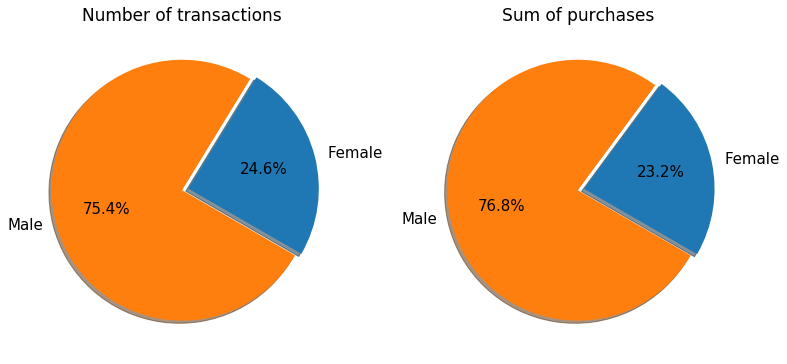

In [10]:
plt.figure(figsize=(13, 6))
gender_gb = df[['Gender', 'Purchase']].groupby('Gender').agg(['count', 'sum'])
params = {
#     'colors': [(255/255, 102/255, 102/255, 1), (102/255, 179/255, 1, 1)],
    'labels': gender_gb.index.map({'M': 'Male', 'F': 'Female'}),
    'autopct': '%1.1f%%',
    'startangle': -30, 
    'textprops': {'fontsize': 15},
    'explode': (0.05, 0),
    'shadow': True
}
plt.subplot(121)
plt.pie(gender_gb['Purchase']['count'], **params)
plt.title('Number of transactions', size=17)
plt.subplot(122)
plt.pie(gender_gb['Purchase']['sum'], **params)
plt.title('Sum of purchases', size=17)
plt.show()

Men have had transactions about 3 times higher than women in black friday. They've also had proportionaly higher purchase amount, which leads to the assumption that there is no meaningful difference between mean purchase amounts of men and women. Let's check that.

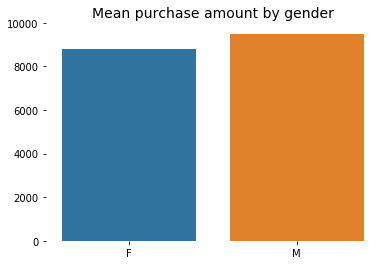

In [11]:
gender_gb = df[['Gender', 'Purchase']].groupby('Gender', as_index=False).agg('mean')
sns.barplot(x='Gender', y='Purchase', data=gender_gb)
plt.ylabel('')
plt.xlabel('')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('Mean purchase amount by gender', size=14)
plt.show()

# Age

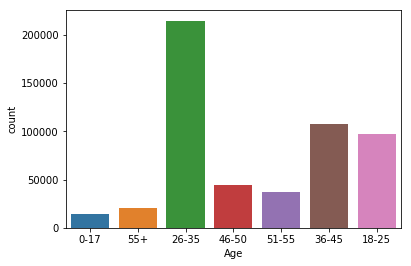

In [12]:
sns.countplot(df['Age'])

Further, I could also check among the age groups, which gender was a majority by adding a hue. And as seen below, more males spent in the sale than females.

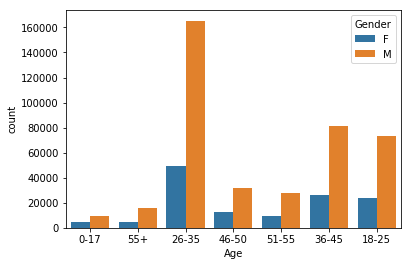

In [13]:
sns.countplot(df['Age'],hue=df['Gender'])

In [14]:
df['combined_G_M'] = df.apply(lambda x:'%s_%s' % (x['Gender'],x['Marital_Status']),axis=1)
print(df['combined_G_M'].unique())

['F_0' 'M_0' 'M_1' 'F_1']


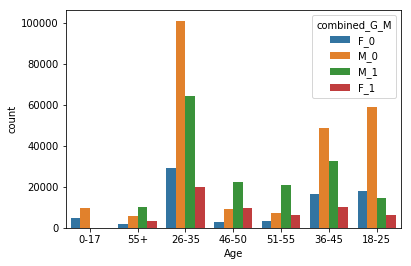

In [15]:
sns.countplot(df['Age'],hue=df['combined_G_M'])

As we see above, there are no bars for the married in the 0-17 range which makes sense. And then if we look at the 46 and above groups, females are very less. But on the other hand, married males paying in range 46-55 are also comparatively more than married females. So it could also imply that though ladies do shop a lot, their spouses are possibly paying for it and hence data reflects that men shopped more. If we had more categorical data defining what kind of products were purchased by men, we could dig in this statement further. However, since in this dataset we don't know if there is a category that implies feminine products/clothes we cannot further explore this case.

In [16]:
df.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023024,0.018732,0.003687,0.001471,0.004045,0.005389
Occupation,-0.023024,1.000000,0.024691,-0.008114,-0.000031,0.013452,0.021104
Marital_Status,0.018732,0.024691,1.000000,0.020546,0.015116,0.019452,0.000129
Product_Category_1,0.003687,-0.008114,0.020546,1.000000,0.540423,0.229490,-0.314125
Product_Category_2,0.001471,-0.000031,0.015116,0.540423,1.000000,0.543544,-0.209973
Product_Category_3,0.004045,0.013452,0.019452,0.229490,0.543544,1.000000,-0.022257
Purchase,0.005389,0.021104,0.000129,-0.314125,-0.209973,-0.022257,1.000000


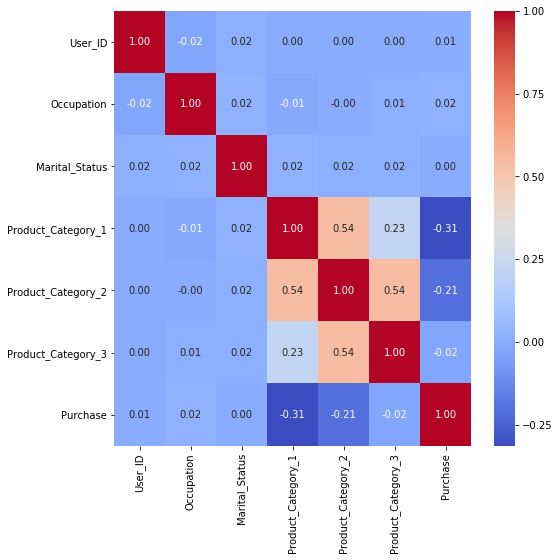

In [17]:
plt.figure(figsize=(8,8))
sns.heatmap(data=df.iloc[:,:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

# H20

In [18]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [19]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [20]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [21]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

9aTclywXj


In [22]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:13222 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmp546bhngo
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmp546bhngo\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmp546bhngo\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:13222
Connecting to H2O server at http://127.0.0.1:13222 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_vrush_v9pnwh
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [23]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555442139.0373821, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 500, 'run_id': '9aTclywXj', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555442139.0373821, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\9aTclywXj', 'nthreads': 1, 'min_mem_size': 5, 'analysis': 0}


In [24]:
df.to_csv('train1.csv')

In [25]:
data_path='train1.csv'


In [30]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
train_data.head()

C1,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
0,1e+06,P00069042,F,0-17,10,A,2,0,3,nan,nan,8370,F_0
1,1e+06,P00248942,F,0-17,10,A,2,0,1,6,14,15200,F_0
2,1e+06,P00087842,F,0-17,10,A,2,0,12,nan,nan,1422,F_0
3,1e+06,P00085442,F,0-17,10,A,2,0,12,14,nan,1057,F_0
4,1e+06,P00285442,M,55+,16,C,nan,0,8,nan,nan,7969,M_0
5,1e+06,P00193542,M,26-35,15,A,3,0,1,2,nan,15227,M_0
6,1e+06,P00184942,M,46-50,7,B,2,1,1,8,17,19215,M_1
7,1e+06,P00346142,M,46-50,7,B,2,1,1,15,nan,15854,M_1
8,1e+06,P0097242,M,46-50,7,B,2,1,1,16,nan,15686,M_1
9,1.00000e+06,P00274942,M,26-35,20,A,1,1,8,nan,nan,7871,M_1


In [32]:
train_data.describe()

Rows:537577
Cols:14




,C1,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
type,int,int,enum,enum,enum,int,enum,int,int,int,int,int,int,enum
mins,0.0,1000001.0,,,,0.0,,0.0,0.0,1.0,2.0,3.0,185.0,
mean,268788.0,1002991.8470284262,,,,8.08271001177507,,1.4692404461960729,0.4087972513705013,5.295546498455105,9.842144034798466,12.669840149015695,9333.859852635058,
maxs,537576.0,1006040.0,,,,20.0,,3.0,1.0,18.0,18.0,18.0,23961.0,
sigma,155185.2571675759,1714.3926953608495,,,,6.524119769935606,,0.9896412335601001,0.4916121522296775,3.7507009498797923,5.087259152856601,4.124341017353132,4981.02213265648,
zeros,1,0,,,,68120,,72725,317817,0,0,0,0,
missing,0,0,0,0,0,0,0,82889,0,0,166986,373299,0,0
0,0.0,1000001.0,P00069042,F,0-17,10.0,A,2.0,0.0,3.0,nan,nan,8370.0,F_0
1,1.0,1000001.0,P00248942,F,0-17,10.0,A,2.0,0.0,1.0,6.0,14.0,15200.0,F_0
2,2.0,1000001.0,P00087842,F,0-17,10.0,A,2.0,0.0,12.0,nan,nan,1422.0,F_0


In [33]:
target = 'Purchase'

In [34]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [35]:
print(X)
print(y)

['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']
Purchase


In [36]:
# setup autoML
run_time=500
aml = H2OAutoML(max_runtime_secs=run_time)

In [37]:
logs_path = os.getcwd()
logfile = 'logs.txt'

In [38]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [39]:
# view leaderboard
lb = aml.leaderboard
lb.head(500)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190416_151701,6.97055e+06,2640.18,6.97055e+06,1972.75,nan
GBM_2_AutoML_20190416_151701,7.9109e+06,2812.63,7.9109e+06,2135.32,0.38789
DRF_1_AutoML_20190416_151701,7.92068e+06,2814.37,7.92068e+06,2120.74,0.392668
StackedEnsemble_AllModels_AutoML_20190416_151701,1.44352e+07,3799.37,1.44352e+07,3009.28,0.547956
StackedEnsemble_BestOfFamily_AutoML_20190416_151701,1.64811e+07,4059.69,1.64811e+07,3236.09,0.575729
GLM_grid_1_AutoML_20190416_151701_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [40]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [42]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [43]:

mod_best._id

'GBM_1_AutoML_20190416_151701'

# Hyperparameters are amongst below generated

In [44]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190416_151701',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190416_151701'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': '

In [45]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [46]:
hy_parameter = mod_best.params
n='hyperparameter1_500.json'

In [47]:
dict_to_json(hy_parameter,n)

# H2O Model 2 for 500 seconds

In [48]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])

In [49]:
mod_best._id

'GBM_2_AutoML_20190416_151701'

In [50]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190416_151701',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190416_151701'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': '

In [51]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [52]:
hy_parameter = mod_best.params
n='hyperparameter2_500.json'

In [53]:
dict_to_json(hy_parameter,n)

# H2O Model 3 for 500 seconds

In [54]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [55]:
mod_best._id

'DRF_1_AutoML_20190416_151701'

In [56]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190416_151701',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190416_151701'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': '

In [57]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [58]:
hy_parameter = mod_best.params
n='hyperparameter3_500.json'

In [59]:
dict_to_json(hy_parameter,n)

# H2O Model 4 for 500 seconds

In [62]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [63]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190416_151701'

In [64]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190416_151701',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190416_151701'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name'

In [65]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [66]:
hy_parameter = mod_best.params
n='hyperparameter4_500.json'

In [67]:
dict_to_json(hy_parameter,n)

# H2O Model 5 for 500 Seconds


In [68]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [69]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190416_151701'

In [70]:

# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190416_151701',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190416_151701'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema

In [71]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [72]:
hy_parameter = mod_best.params
n='hyperparameter5_500.json'

In [73]:
dict_to_json(hy_parameter,n)

# H2O Model 6 for 500 Seconds

In [74]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])

In [75]:
mod_best._id

'GLM_grid_1_AutoML_20190416_151701_model_1'

In [76]:

# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190416_151701_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190416_151701_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train11.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train11.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 2938085526509567255},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fo

In [77]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [78]:
hy_parameter = mod_best.params
n='hyperparameter6_500.json'

In [79]:
dict_to_json(hy_parameter,n)

# H2O Model for 1000 Seconds

In [80]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [81]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [82]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [83]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

Hc4K9U9pf


In [84]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:28768 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmp177qgbi5
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmp177qgbi5\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmp177qgbi5\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:28768
Connecting to H2O server at http://127.0.0.1:28768 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_vrush_3u4tf3
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [85]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555444098.7387574, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\9aTclywXj', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 1000, 'run_id': 'Hc4K9U9pf', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555444098.7387574, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\9aTclywXj\\Hc4K9U9pf', 'nthreads': 1, 'min_mem_size': 3, 'analysis': 0}


In [86]:
df.to_csv('train1.csv')

In [87]:
data_path='train1.csv'


In [88]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [89]:
target = 'Purchase'

In [90]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [91]:
# setup autoML
run_time=1000
aml = H2OAutoML(max_runtime_secs=run_time)

In [92]:
logs_path = os.getcwd()
logfile = 'logs.txt'

In [93]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [94]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190416_154932,6.62925e+06,2574.73,6.62925e+06,1907.43,nan
GBM_4_AutoML_20190416_154932,6.66137e+06,2580.96,6.66137e+06,1920.02,nan
GBM_3_AutoML_20190416_154932,6.77356e+06,2602.61,6.77356e+06,1941.15,nan
GBM_2_AutoML_20190416_154932,6.86883e+06,2620.85,6.86883e+06,1955.92,nan
GBM_1_AutoML_20190416_154932,6.94847e+06,2636,6.94847e+06,1968.13,nan
DRF_1_AutoML_20190416_154932,8.24042e+06,2870.61,8.24042e+06,2163.46,0.405858
StackedEnsemble_AllModels_AutoML_20190416_154932,1.08029e+07,3286.78,1.08029e+07,2567.39,0.487381
StackedEnsemble_BestOfFamily_AutoML_20190416_154932,1.6485e+07,4060.17,1.6485e+07,3236.93,0.575928
GLM_grid_1_AutoML_20190416_154932_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [95]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [97]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [98]:
mod_best._id

'GBM_5_AutoML_20190416_154932'

# Hyperparameters are amongst following

In [99]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [100]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [101]:
hy_parameter = mod_best.params
n='hyperparameter1_1000.json'

In [102]:
dict_to_json(hy_parameter,n)

# H2O Model 2 for 1000 Seconds

In [103]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])

In [104]:
mod_best._id

'GBM_4_AutoML_20190416_154932'

In [105]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [106]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [107]:
hy_parameter = mod_best.params
n='hyperparameter2_1000.json'

In [108]:
dict_to_json(hy_parameter,n)

# H2O Model 3 for 1000 seconds

In [109]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [110]:
mod_best._id

'GBM_3_AutoML_20190416_154932'

In [111]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [112]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [113]:
hy_parameter = mod_best.params
n='hyperparameter3_1000.json'

In [114]:
dict_to_json(hy_parameter,n)

# H2O Model 4 for 1000 Seconds

In [115]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [116]:
mod_best._id

'GBM_2_AutoML_20190416_154932'

In [117]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [118]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [119]:
hy_parameter = mod_best.params
n='hyperparameter4_1000.json'

In [120]:
dict_to_json(hy_parameter,n)

# H2O Model 5 for 1000 seconds

In [121]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [122]:
mod_best._id

'GBM_1_AutoML_20190416_154932'

In [123]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [124]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [125]:
hy_parameter = mod_best.params
n='hyperparameter5_1000.json'

In [126]:
dict_to_json(hy_parameter,n)

# H2O Model 6 for 1000 Seconds

In [149]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])

In [150]:
mod_best._id

'DRF_1_AutoML_20190416_154932'

In [151]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [152]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [153]:
hy_parameter = mod_best.params
n='hyperparameter6_1000.json'

In [154]:
dict_to_json(hy_parameter,n)

# H2O Model 7 for 1000 Seconds

In [155]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])

In [156]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190416_154932'

In [157]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [158]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [159]:
hy_parameter = mod_best.params
n='hyperparameter7_1000.json'

In [160]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 8 for 1000 Seconds

In [161]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])

In [162]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190416_154932'

In [163]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190416_154932',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190416_154932'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [164]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [165]:
hy_parameter = mod_best.params
n='hyperparameter8_1000.json'

In [166]:
dict_to_json(hy_parameter,n)

# Hyperparameter for model 9 for 1000 seconds

In [167]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])

In [168]:
mod_best._id

'GLM_grid_1_AutoML_20190416_154932_model_1'

In [169]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190416_154932_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190416_154932_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 7554553798172570151},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [170]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [171]:
hy_parameter = mod_best.params
n='hyperparameter9_1000.json'

In [172]:
dict_to_json(hy_parameter,n)

# H2O Model 3

In [245]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [246]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

2


In [247]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [248]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

nmjKijPyX


In [249]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:42863 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpkdje4vzu
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpkdje4vzu\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpkdje4vzu\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:42863
Connecting to H2O server at http://127.0.0.1:42863 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_vrush_h3307c
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [250]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555459605.9320474, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\9aTclywXj\\Hc4K9U9pf\\ad7rvktEw', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 1500, 'run_id': 'nmjKijPyX', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555459605.9320474, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\9aTclywXj\\Hc4K9U9pf\\ad7rvktEw\\nmjKijPyX', 'nthreads': 1, 'min_mem_size': 2, 'analysis': 0}


In [179]:
df.to_csv('train1.csv')

In [180]:
data_path='train1.csv'


In [181]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [182]:
target = 'Purchase'

In [183]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [184]:
# setup autoML
run_time=1500
aml = H2OAutoML(max_runtime_secs=run_time)

In [185]:
logs_path = os.getcwd()
logfile = 'logs.txt'

In [186]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [187]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190416_190838,6.57815e+06,2564.79,6.57815e+06,1898.75,nan
GBM_4_AutoML_20190416_190838,6.61991e+06,2572.92,6.61991e+06,1911.26,nan
GBM_3_AutoML_20190416_190838,6.765e+06,2600.96,6.765e+06,1939.74,nan
GBM_2_AutoML_20190416_190838,6.86895e+06,2620.87,6.86895e+06,1956.33,nan
GBM_1_AutoML_20190416_190838,6.96638e+06,2639.39,6.96638e+06,1971.03,nan
DRF_1_AutoML_20190416_190838,8.19193e+06,2862.15,8.19193e+06,2158.63,0.403952
StackedEnsemble_AllModels_AutoML_20190416_190838,1.07945e+07,3285.5,1.07945e+07,2566.15,0.487278
StackedEnsemble_BestOfFamily_AutoML_20190416_190838,1.64783e+07,4059.35,1.64783e+07,3236.15,0.575882
GLM_grid_1_AutoML_20190416_190838_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [188]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [189]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [190]:
mod_best._id

'GBM_5_AutoML_20190416_190838'

In [191]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [192]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [193]:
hy_parameter = mod_best.params
n='hyperparameter1_1500.json'

In [194]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 2 for 1500 Seconds

In [195]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])

In [196]:
mod_best._id

'GBM_4_AutoML_20190416_190838'

In [197]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [198]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [200]:
hy_parameter = mod_best.params
n='hyperparameter2_1500.json'

In [201]:
dict_to_json(hy_parameter,n)

# Hyperparameter for model 3 for 1500 Seconds

In [203]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [204]:
mod_best._id

'GBM_3_AutoML_20190416_190838'

In [205]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [206]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [207]:
hy_parameter = mod_best.params
n='hyperparameter3_1500.json'

In [208]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 4 for 1500 Seconds

In [209]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [210]:
mod_best._id

'GBM_2_AutoML_20190416_190838'

In [211]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [212]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [213]:
hy_parameter = mod_best.params
n='hyperparameter4_1500.json'

In [214]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 5 for 1500 Seconds

In [215]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [216]:
mod_best._id

'GBM_1_AutoML_20190416_190838'

In [217]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [218]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [219]:
hy_parameter = mod_best.params
n='hyperparameter5_1500.json'

In [220]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 6 for 1500 Seconds

In [221]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])

In [222]:
mod_best._id

'DRF_1_AutoML_20190416_190838'

In [223]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [224]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [225]:
hy_parameter = mod_best.params
n='hyperparameter6_1500.json'

In [226]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 7 for 1500 Seconds

In [227]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])

In [228]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190416_190838'

In [229]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [230]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [231]:
hy_parameter = mod_best.params
n='hyperparameter7_1500.json'

In [237]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 8 for 1500 Seconds

In [232]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])

In [233]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190416_190838'

In [234]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190416_190838',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190416_190838'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [235]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [236]:
hy_parameter = mod_best.params
n='hyperparameter8_1500.json'

In [238]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 9 For 1500 Seconds

In [239]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])

In [240]:
mod_best._id

'GLM_grid_1_AutoML_20190416_190838_model_1'

In [241]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190416_190838_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190416_190838_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': -3094801649326299151},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fol

In [242]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [243]:
hy_parameter = mod_best.params
n='hyperparameter9_1500.json'

In [244]:
dict_to_json(hy_parameter,n)

# H2O Model 4

In [18]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=2000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [19]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [20]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [21]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

5lQszLuFC


In [22]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:6279 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpokgxgs82
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpokgxgs82\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpokgxgs82\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:6279
Connecting to H2O server at http://127.0.0.1:6279 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_vrush_enzppw
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [23]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555467663.7836208, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 2000, 'run_id': '5lQszLuFC', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555467663.7836208, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\5lQszLuFC', 'nthreads': 1, 'min_mem_size': 5, 'analysis': 0}


In [24]:
df.to_csv('train1.csv')

In [25]:
data_path='train1.csv'

In [26]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
target = 'Purchase'

In [28]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [29]:
# setup autoML
run_time=2000
aml = H2OAutoML(max_runtime_secs=run_time)

In [30]:
logs_path = os.getcwd()
logfile = 'logs.txt'

In [31]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [32]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190416_222141,6.55027e+06,2559.35,6.55027e+06,1892.94,nan
GBM_4_AutoML_20190416_222141,6.61653e+06,2572.26,6.61653e+06,1910.35,nan
GBM_3_AutoML_20190416_222141,6.77582e+06,2603.04,6.77582e+06,1940.6,nan
GBM_2_AutoML_20190416_222141,6.85196e+06,2617.62,6.85196e+06,1952.72,nan
GBM_1_AutoML_20190416_222141,6.97429e+06,2640.89,6.97429e+06,1971.57,nan
DeepLearning_1_AutoML_20190416_222141,7.31247e+06,2704.16,7.31247e+06,2018.98,nan
DRF_1_AutoML_20190416_222141,9.02593e+06,3004.32,9.02593e+06,2264.33,0.431603
StackedEnsemble_AllModels_AutoML_20190416_222141,1.02189e+07,3196.7,1.02189e+07,2489.79,0.475411
StackedEnsemble_BestOfFamily_AutoML_20190416_222141,1.44237e+07,3797.85,1.44237e+07,3008.8,0.54844
GLM_grid_1_AutoML_20190416_222141_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [33]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [34]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [35]:
mod_best._id

'GBM_5_AutoML_20190416_222141'

In [36]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [37]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [38]:
hy_parameter = mod_best.params
n='hyperparameter1_2000.json'

In [39]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 2 for 2000 Seconds

In [40]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])

In [41]:
mod_best._id

'GBM_4_AutoML_20190416_222141'

In [42]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [43]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [55]:
hy_parameter = mod_best.params
n='hyperparameter2_2000.json'

In [56]:
dict_to_json(hy_parameter,n)

# Hyperparameters for model 2 for 2000 Seconds

In [45]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [46]:
mod_best._id

'GBM_3_AutoML_20190416_222141'

In [47]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [48]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [57]:
hy_parameter = mod_best.params
n='hyperparameter3_2000.json'

In [58]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 4 for 2000 Seconds

In [50]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [51]:
mod_best._id

'GBM_2_AutoML_20190416_222141'

In [52]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [53]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [59]:
hy_parameter = mod_best.params
n='hyperparameter4_2000.json'

In [60]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 5 for 2000 Seconds

In [61]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [62]:
mod_best._id

'GBM_1_AutoML_20190416_222141'

In [63]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [64]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [65]:
hy_parameter = mod_best.params
n='hyperparameter5_2000.json'

In [66]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 6 for 2000 Seconds

In [76]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])

In [77]:
mod_best._id

'DeepLearning_1_AutoML_20190416_222141'

In [78]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_1_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_1_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': None},
 'response_column': 

In [70]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [71]:
hy_parameter = mod_best.params
n='hyperparameter6_2000.json'

In [72]:
dict_to_json(hy_parameter,n)

# Hyperparameters for model 7 for 2000 Seconds

In [79]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])

In [80]:
mod_best._id

'DRF_1_AutoML_20190416_222141'

In [81]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [82]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [83]:
hy_parameter = mod_best.params
n='hyperparameter7_2000.json'

In [84]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 8 for 2000 Seconds

In [105]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])

In [106]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190416_222141'

In [107]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [108]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [109]:
hy_parameter = mod_best.params
n='hyperparameter8_2000.json'

In [110]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 9 for 2000 Seconds

In [111]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])

In [112]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190416_222141'

In [113]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190416_222141',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190416_222141'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [114]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [115]:
hy_parameter = mod_best.params
n='hyperparameter9_2000.json'

In [116]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 10 for 2000 Seconds

In [99]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[9])

In [100]:
mod_best._id

'GLM_grid_1_AutoML_20190416_222141_model_1'

In [101]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190416_222141_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190416_222141_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 3259049994933407152},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [102]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [103]:
hy_parameter = mod_best.params
n='hyperparameter10_2000.json'

In [104]:
dict_to_json(hy_parameter,n)

# H2O Model5

In [117]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=2500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [118]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [119]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [120]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

ll5x6BXX6


In [121]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:22496 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpgtzm0cid
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpgtzm0cid\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpgtzm0cid\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:22496
Connecting to H2O server at http://127.0.0.1:22496 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_vrush_m01a6v
H2O cluster total nodes:,1
H2O cluster free memory:,3.833 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [122]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555473113.2784011, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\5lQszLuFC', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 2500, 'run_id': 'll5x6BXX6', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555473113.2784011, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\black-friday\\5lQszLuFC\\ll5x6BXX6', 'nthreads': 1, 'min_mem_size': 4, 'analysis': 0}


In [123]:
df.to_csv('train1.csv')

In [124]:
data_path='train1.csv'

In [125]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [126]:
target = 'Purchase'

In [127]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [128]:
# setup autoML
run_time=2500
aml = H2OAutoML(max_runtime_secs=run_time)

In [129]:
logs_path = os.getcwd()
logfile = 'logs.txt'

In [130]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [131]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190416_235225,6.5359e+06,2556.54,6.5359e+06,1891.25,nan
GBM_4_AutoML_20190416_235225,6.63833e+06,2576.5,6.63833e+06,1915.21,nan
GBM_3_AutoML_20190416_235225,6.74257e+06,2596.65,6.74257e+06,1933.7,nan
GBM_2_AutoML_20190416_235225,6.86087e+06,2619.33,6.86087e+06,1954.31,nan
GBM_1_AutoML_20190416_235225,6.95863e+06,2637.92,6.95863e+06,1970.24,nan
DeepLearning_1_AutoML_20190416_235225,7.3317e+06,2707.71,7.3317e+06,2014.29,nan
DRF_1_AutoML_20190416_235225,8.48362e+06,2912.67,8.48362e+06,2195.74,0.414412
XRT_1_AutoML_20190416_235225,8.98243e+06,2997.07,8.98243e+06,2263.63,0.422218
StackedEnsemble_AllModels_AutoML_20190416_235225,9.07923e+06,3013.18,9.07923e+06,2319.38,0.448756
GBM_grid_1_AutoML_20190416_235225_model_2,9.36139e+06,3059.64,9.36139e+06,2355.88,0.450477


In [132]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [133]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [134]:
mod_best._id

'GBM_5_AutoML_20190416_235225'

In [135]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [136]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [137]:
hy_parameter = mod_best.params
n='hyperparameter1_2500.json'

In [138]:
dict_to_json(hy_parameter,n)

# H2O Model 2 for 2500 Seconds

In [139]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])

In [140]:
mod_best._id

'GBM_4_AutoML_20190416_235225'

In [141]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [142]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [143]:
hy_parameter = mod_best.params
n='hyperparameter2_2500.json'

In [144]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 3

In [157]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [158]:
mod_best._id

'GBM_3_AutoML_20190416_235225'

In [159]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [160]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [161]:
hy_parameter = mod_best.params
n='hyperparameter3_2500.json'

In [162]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model4

In [163]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [164]:
mod_best._id

'GBM_2_AutoML_20190416_235225'

In [165]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [166]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [167]:
hy_parameter = mod_best.params
n='hyperparameter4_2500.json'

In [168]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 5

In [169]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [170]:
mod_best._id

'GBM_1_AutoML_20190416_235225'

In [171]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [172]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [173]:
hy_parameter = mod_best.params
n='hyperparameter5_2500.json'

In [174]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 6

In [175]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])

In [176]:
mod_best._id

'DeepLearning_1_AutoML_20190416_235225'

In [177]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_1_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_1_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': None},
 'response_column': 

In [178]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [179]:
hy_parameter = mod_best.params
n='hyperparameter6_2500.json'

In [180]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 7

In [181]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])

In [182]:
mod_best._id

'DRF_1_AutoML_20190416_235225'

In [183]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [184]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [185]:
hy_parameter = mod_best.params
n='hyperparameter7_2500.json'

In [186]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 8

In [187]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])

In [188]:
mod_best._id

'XRT_1_AutoML_20190416_235225'

In [189]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XRT_1_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/XRT_1_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [190]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [191]:
hy_parameter = mod_best.params
n='hyperparameter8_2500.json'

In [192]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 9

In [193]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])

In [194]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190416_235225'

In [195]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [196]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [197]:
hy_parameter = mod_best.params
n='hyperparameter9_2500.json'

In [198]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 10

In [199]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[9])

In [200]:
mod_best._id

'GBM_grid_1_AutoML_20190416_235225_model_2'

In [201]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190416_235225_model_2',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190416_235225_model_2'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_as

In [202]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [203]:
hy_parameter = mod_best.params
n='hyperparameter10_2500.json'

In [204]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 11

In [205]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[10])

In [206]:
mod_best._id

'GBM_grid_1_AutoML_20190416_235225_model_3'

In [207]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190416_235225_model_3',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190416_235225_model_3'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_as

In [208]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [209]:
hy_parameter = mod_best.params
n='hyperparameter11_2500.json'

In [210]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 12

In [212]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[11])

In [213]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190416_235225'

In [214]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190416_235225',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190416_235225'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [215]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [216]:
hy_parameter = mod_best.params
n='hyperparameter12_2500.json'

In [217]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 13

In [218]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[12])

In [219]:
mod_best._id

'GBM_grid_1_AutoML_20190416_235225_model_1'

In [220]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190416_235225_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190416_235225_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_as

In [221]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [222]:
hy_parameter = mod_best.params
n='hyperparameter13_2500.json'

In [223]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 14

In [224]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[13])

In [225]:
mod_best._id

'GLM_grid_1_AutoML_20190416_235225_model_1'

In [226]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190416_235225_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190416_235225_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 3850681770674218579},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [227]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [228]:
hy_parameter = mod_best.params
n='hyperparameter14_2500.json'

In [229]:
dict_to_json(hy_parameter,n)